In [1]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [22]:
def declare_project_selection(alpha):
    mu = [20, 40, 20, 15, 30]  # Expected returns from each project
    constraints = [
        [5, 4, 3, 7, 8],  # restriction 1
        [5, 7, 9, 4, 6],  # restriction 2
        [8, 10, 2, 3, 10],  # restriction 3
    ]
    rhs = [25, 25, 25]
    
    n = len(mu)  # Number of projects
    
    # Initialize Quadratic Program
    projectSelectionQP = QuadraticProgram("Project Selection")
    
    for i in range(n):
        projectSelectionQP.binary_var(name=f'x{i}')

    linear = [-mu[i] for i in range(n)]
    projectSelectionQP.minimize(linear=dict(zip([f'x{i}' for i in range(n)], linear)))

    for k, (constraint, limit) in enumerate(zip(constraints, rhs)):

        penalty = {f'x{i}': coef for i, coef in enumerate(constraint)}
    

        projectSelectionQP.minimize(
            quadratic={(f'x{i}', f'x{j}'): alpha * penalty[f'x{i}'] * penalty[f'x{j}']
                   for i in range(n) for j in range(n)},
            linear={f'x{i}': -2 * alpha * limit * penalty[f'x{i}'] for i in range(n)},
            constant=alpha * limit**2
        )
    
    return projectSelectionQP

In [4]:
def declare_qubo_problem(classic_problem, penalty):
    #Convert a classical quadratic problem to a QUBO problem.
    qubo_problem = QuadraticProgramToQubo(penalty=penalty).convert(classic_problem)
    return qubo_problem

In [6]:
def hamiltonian_offset(qubo_problem):
    #Extract the Hamiltonian and offset from a QUBO problem.
    return qubo_problem.to_ising()

In [5]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [23]:
alpha = 1.0 

classic_problem = declare_project_selection(alpha)
print(classic_problem.prettyprint())

Problem name: Project Selection

Minimize
  64*x0^2 + 160*x0*x1 + 32*x0*x2 + 48*x0*x3 + 160*x0*x4 + 100*x1^2 + 40*x1*x2
  + 60*x1*x3 + 200*x1*x4 + 4*x2^2 + 12*x2*x3 + 40*x2*x4 + 9*x3^2 + 60*x3*x4
  + 100*x4^2 - 400*x0 - 500*x1 - 100*x2 - 150*x3 - 500*x4 + 625

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



In [24]:
penalty = 1

qubo_problem = declare_qubo_problem(classic_problem, penalty)
print(qubo_problem.prettyprint()) 

hamiltonian, offset = hamiltonian_offset(qubo_problem)

Problem name: Project Selection

Minimize
  64*x0^2 + 160*x0*x1 + 32*x0*x2 + 48*x0*x3 + 160*x0*x4 + 100*x1^2 + 40*x1*x2
  + 60*x1*x3 + 200*x1*x4 + 4*x2^2 + 12*x2*x3 + 40*x2*x4 + 9*x3^2 + 60*x3*x4
  + 100*x4^2 - 400*x0 - 500*x1 - 100*x2 - 150*x3 - 500*x4 + 625

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



In [26]:
values = {'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 0}
qubo_problem.objective.evaluate([values[f'x{i}'] for i in range(1, 6)])

4.0

In [28]:
best_values = {'x1': 1, 'x2': 0, 'x3': 1, 'x4': 1, 'x5': 1}
worst_values_feasible = {'x1': 0, 'x2': 0, 'x3': 0, 'x4': 0, 'x5': 0}
worst_values = {'x1': 1, 'x2': 1, 'x3': 1, 'x4': 1, 'x5': 0}

f_min = qubo_problem.objective.evaluate([best_values[f'x{i}'] for i in range(1, 6)])
f_max = qubo_problem.objective.evaluate([worst_values_feasible[f'x{i}'] for i in range(1, 6)])

print("F_max:", f_max)
print("F_min:", f_min)

F_max: 625.0
F_min: 4.0


In [29]:
def r(z, problem):
    return (problem.objective.evaluate(z) - f_max) / (f_min - f_max)

In [30]:
r([best_values[f'x{i}'] for i in range(1, 6)], qubo_problem), r([worst_values_feasible[f'x{i}'] for i in range(1, 6)], qubo_problem), r([worst_values[f'x{i}'] for i in range(1, 6)], qubo_problem)

(1.0, -0.0, 1.0)

In [35]:
def run_experiment_performance_measurement(n_range, p, shots_estimator, shots_sampler, level, h, qubo_problem):
    aer_sim = AerSimulator()
    pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=level)

    ansatz = QAOAAnsatz(h, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = h.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    
    results_x = []
    for i in range(n_range):
        x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
        ansatz_isa.decompose(reps=3).draw(output="mpl", style="iqp")
        results_x.append(res.x)
    results_x_mean = np.mean(results_x, axis=0)

    qc = ansatz.assign_parameters(results_x_mean)
    qc.measure_all()
    qc_isa = pm.run(qc)

    result = sampler.run([qc_isa]).result()
    variables = [list(map(int, key)) for key in result[0].data.meas.get_counts().keys()]

    approx_ratios = [r(z, qubo_problem) for z in variables]
    mean_approx_ratio = np.mean(approx_ratios)
    std_dev_approx_ratio = np.std(approx_ratios)
    percent_between_0_and_1 = (sum(0 <= ratio <= 1 for ratio in approx_ratios) / len(approx_ratios)) * 100

    approx_ratios_pos = [r(z, qubo_problem) for z in variables if r(z, qubo_problem) >= 0]
    mean_approx_ratio_pos = np.mean(approx_ratios_pos)
    std_dev_approx_ratio_pos = np.std(approx_ratios_pos)
    
    return mean_approx_ratio, std_dev_approx_ratio, percent_between_0_and_1, mean_approx_ratio_pos, std_dev_approx_ratio_pos

In [36]:
def run_experiment_performance_measurement_alpha(alpha, n_range, p, shots_estimator, shots_sampler, level):
    c_problem = declare_project_selection(alpha)

    qubo = declare_qubo_problem(c_problem, 1)

    hamiltonian, offset = hamiltonian_offset(qubo)

    return run_experiment_performance_measurement(n_range, p, shots_estimator, shots_sampler, level, hamiltonian, qubo)

In [37]:
alpha_values = list([1, 10, 100, 1000, 10000, 100000])

r_means_alpha = []
r_stds_alpha = []

for alpha in alpha_values:
    mean_r, std_r, percent_r, mean_r_pos, std_r_pos = run_experiment_performance_measurement_alpha(alpha, 40, 3, 1000, 1000, 1)
    r_means_alpha.append(mean_r_pos)
    r_stds_alpha.append(std_r_pos)

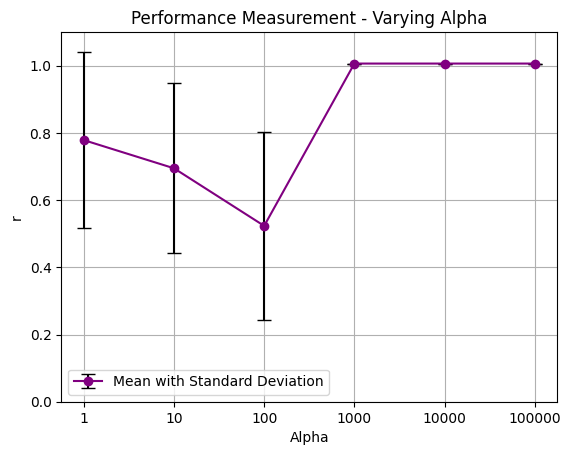

In [38]:
plt.errorbar(range(len(alpha_values)), r_means_alpha, yerr=r_stds_alpha, fmt='o-', color='purple', ecolor='black', capsize=5, label="Mean with Standard Deviation")

plt.xticks(range(len(alpha_values)), alpha_values)
plt.xlabel("Alpha")
plt.ylabel("r")
plt.title("Performance Measurement - Varying Alpha")
plt.ylim(0.0, 1.1)
plt.grid(True)
plt.legend()
plt.show()